In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

from auxiliary import plot_conditional_expectation_demonstration_1
from auxiliary import plot_predictions_demonstration_1
from auxiliary import get_sample_regression_adjustment
from auxiliary import get_sample_demonstration_1
from auxiliary import plot_freedman_exercise
from auxiliary import plot_anscombe_dataset
from auxiliary import get_anscombe_datasets
from auxiliary import run_freedman_exercise
from auxiliary import get_quick_sample

np.random.seed(123)

# Regression estimators of causal effects

**Overview**

* Regression as a descriptive tool

* Regression adjustment as a strategy to to estimate causal effects

* Regression as conditional-variance-weighted matching

* Regression as an implementation of a perfect stratification

* Regression as supplemental adjustment when matching

* Extensions and other perspectives

* Conclusion
    

We start with different ways of using regression

* descriptive tools
    * Anscombe quartet
    
* estimating causal effects

* Freedman's paradox

### Regression as a descriptive tool

Goldberger (1991) motivates least squares regression as a technique to estimate a **best-fitting** linear approximation to a conditional expectation function that may be nonlinear in the population.

**Best** is defined as minimizing the average squared differences between the fitted values and the true values of the conditional expectations functions.

<img src="material/fig-regression-demonstration-one.png" width="500" />

In [18]:
df = get_sample_demonstration_1(num_agents=10000)
df.head()

,Y,D,S,Y_1,Y_0
0,0.113157,0,1,4.055376,0.113157
1,9.479227,0,3,14.146062,9.479227
2,0.409400,0,1,2.081023,0.409400
3,7.087262,1,2,7.087262,5.145585
4,3.338352,0,1,2.825938,3.338352


In [19]:
df.groupby(["D", "S"])["Y"].mean()

D  S
0  1     2.014537
   2     6.032069
   3     9.976885
1  1     4.067050
   2     8.028103
   3    14.025534
Name: Y, dtype: float64

How does the functional form of the conditional expectation look like?

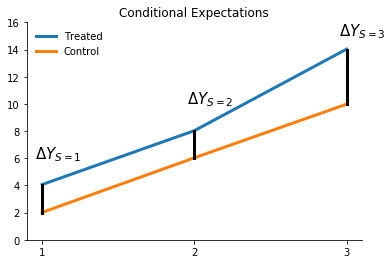

In [20]:
plot_conditional_expectation_demonstration_1(df)

What does the difference between the two lines tell us about treatment effect heterogeneity?

We will fit four different prediction models using ordinary least squares.

\begin{align*}
&\hat{Y} = \beta_0 + \beta_1 D + \beta_2 S \\
&\hat{Y} = \beta_0 + \beta_1 D + \beta_2 S_1 + \beta_3 S_2 \\
&\hat{Y} = \beta_0 + \beta_1 D + \beta_2 S_1 + \beta_3 S_2 + \beta_4 S_1 * D + \beta_5 S_2 * D  
\end{align*}


In [21]:
rslt = smf.ols(formula="Y ~ D + S", data=df).fit()
rslt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 8.018e+04
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        07:30:39   Log-Likelihood:                -15339.
No. Observations:               10000   AIC:                         3.068e+04
Df Residuals:                    9997   BIC:                         3.071e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6594      0.027    -98.877      0.000      -2.712      -2.607
D              2.7202      0.025    108.756      0.000       2.671       2.769
S              4.4181      0.014    311.459      0.000       4.390       4.446
==============================================================================
Omnibus:                        1.627   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.443   Jarque-Bera (JB):                1.637
Skew:                           0.016   Prob(JB):                        0.441
Kurtosis:                       2.946   Cond. No.                         6.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
df["predict"] = rslt.predict()
df.groupby(["D", "S"])[["Y", "predict"]].mean()

Y    predict
D S                      
0 1   2.014537   1.758657
  2   6.032069   6.176733
  3   9.976885  10.594808
1 1   4.067050   4.478865
  2   8.028103   8.896941
  3  14.025534  13.315017

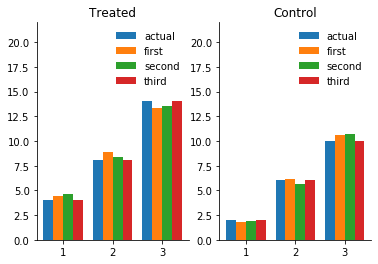

In [23]:
plot_predictions_demonstration_1(df)

#### Anscombe quartet

The best linear approximation can be the same for very different functions. The **Anscombe quartet** (Anscombe, 1973) and many other useful datasets are available in `statsmodels` as part of the  [Datasets Package](https://www.statsmodels.org/0.8.0/datasets/index.html).

In [30]:
df1, df2, df3, df4 = get_anscombe_datasets()
for i, df in enumerate([df1, df2, df3, df4]):
    rslt = smf.ols(formula="y ~ x", data=df).fit()
    print(f"\n Dataset {i}")
    print(" Intercept: {:5.3f} x: {:5.3f}".format(*rslt.params))


 Dataset 0
 Intercept: 3.000 x: 0.500

 Dataset 1
 Intercept: 3.001 x: 0.500

 Dataset 2
 Intercept: 3.002 x: 0.500

 Dataset 3
 Intercept: 3.002 x: 0.500


So what does the data behind these regressions look like?

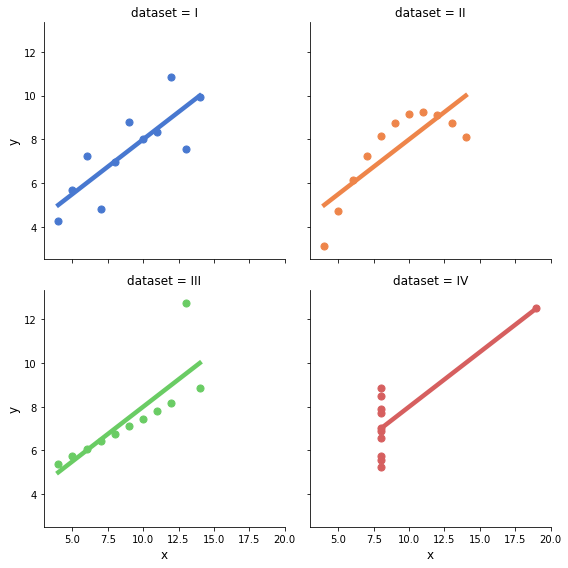

In [31]:
plot_anscombe_dataset()

### Regression adjustment as a strategy to estimate causal effects

#### Regression models and omitted-variable bias

\begin{align*}
Y = \alpha + \delta D + \epsilon
\end{align*}

* $\delta$ is interpreted as an invariant, structural causal effect that applies to all members 
of the population.

* $\epsilon$ is a summary random variable that represents all other causes of $Y$.

\begin{align*}
\hat{\delta}_{OLS, \text{bivariate}} = \frac{Cov_N(y_i, d_i)}{Var_N(d_i)}
\end{align*}

It now depends on the correlation between $\epsilon$ and $D$ whether $\hat{\delta}$ provides an 
unbiased and consistent estimate of the true causal effect

<img src="material/fig-omitted-variable-bias.png" width="300" />

We now move to the potential outcomes model to clarify the connection between  **omitted-variable 
bias** and **self-selection bias**. 

### Potential outcomes and omitted-variable bias

\begin{align*}
Y = \underbrace{\mu^0}_{\alpha} + \underbrace{(\mu^1 - \mu^0)}_{\delta} D + \underbrace{\{\nu^0 + D(\nu^1 - \nu^0 )\}}_{\epsilon}, 
\end{align*}

where $\mu^0\equiv E[Y^0]$, $\mu^1\equiv E[Y^1]$, $\nu^0\equiv Y^0 - E[Y^0]$, and $\nu^1\equiv 
Y^1 - E[Y^1]$.

What induces a correlation between $D$ an $\{\nu^0 + D(\nu^1 - \nu^0 )\}$?

* **baseline bias**, there is a net baseline difference in the hypothetical no-treatment state that
 is correlated with treatment uptake
$\rightarrow$ $D$ is correlated with $\nu_0$

* **differential treatment bias**, there is a net treatment effect difference that is correlated 
with treatment uptake
$\rightarrow$ $D$ is correlated with $D(\nu^1 - \nu^0 )$

<img src="material/fig-regression-demonstration-two.png" height="300" width="300" />

**Errata** 

Please note that there is a relevant correction on the author's [website](http://socweb.soc.jhu.edu/faculty/morgan/papers/Errata_2nd_Edition.pdf):

* page 198, Table 6.2, first panel: In order to restrict the bias to differential baseline  bias only, as required by the label on the first panel of the table, replace 20 with 10 in the first cell of the second row.Then, carry the changes across columns so that (a) the values for  $\nu^1_i$ are 5 for the individual in the treatment group and -5 for the individual in the control group and (b) the value for ${\nu^0_i + D(\nu^1_i − \nu^0_i)}$ is 5 for the individual in the treatment group

| Group   | $y_i^1$ | $y_i^0$ | $\nu_i^1$ | $\nu_i^0$ | $y_i$ | $d_i$ | $\nu_i^1 + d_i (\nu_i^1 - \nu_i^0)$ |  $ d_i (\nu_i^1 - \nu_i^0)$ |
| ------- | ------  | ------- | --------- | --------- | ----- | ----- | ----------------------------------- | --------------------------- |
| Treated | 20      | 10      | 5         |  5         | 20   | 1     |  5.000000000000000000000000         |   0.000000000               |
| Control | 10      |  0      | -5         | -5         |  0   | 0     | -5                                 |   0.000000000               |

### Regression as adjustment for otherwise omitted variables

<img src="material/fig-observable-regression-adjustment.png" width="300" />

We first want to illustrate how we can *subtract out* the dependence between $D$ and $Y$ induced by their common determinant $X$. Let's quickly simulate a parameterized example:

\begin{align*}
D & = I[X + \eta > 0]  \\
Y & = D + X + \epsilon,
\end{align*}
where $(\eta,  \epsilon)$ follow a standard normal distribution.

In [118]:
df = get_quick_sample(num_samples=1000)

We now first run a complete regression.

In [122]:
stat = smf.ols(formula="Y ~ D + X", data=df).fit().params[1]
print(f"Estimated effect: {stat:5.3f}")

Estimated effect: 0.924


However, as it turns out, we can also get the identical estimate by first partialling out the effect of $X$ on $D$ as well as $Y$. 

In [127]:
df_resid = pd.DataFrame(columns=["Y_resid", "D_resid"])
for label in ["Y", "D"]:
    column, formula = f"{label}_resid", f"{label} ~ X"
    df_resid.loc[:, column] = smf.ols(formula=formula, data=df).fit().resid

smf.ols(formula="Y_resid ~ D_resid", data=df_resid).fit().params[1]
print(f"Estimated effect: {stat:5.3f}")

Estimated effect: 0.924


We will now look at two datasets that are observationally equivalent but regression adjustment 
for observable $X$ does only work in one of them.

<img src="material/fig-regression-demonstration-four.png" width="500" />

**Note**

* The naive estimates will be identical as the observed values $y_i$ and $d_i$ are the same.

In [40]:
for sample in range(2):

    df = get_sample_regression_adjustment(sample)
    print("Sample {:}\n".format(sample))

    stat = (df["Y_1"] - df["Y_0"]).mean()
    print("True effect:    {:5.4f}".format(stat))

    stat = df.query("D == 1")["Y"].mean() - df.query("D == 0")["Y"].mean()
    print("Naive estimate: {:5.4f}".format(stat))

    rslt = smf.ols(formula="Y ~ D", data=df).fit()
    print(rslt.summary())

Sample 0

True effect:    10.0000
Naive estimate: 11.6540
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     6113.
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        11:44:40   Log-Likelihood:                -2275.1
No. Observations:                1000   AIC:                             4554.
Df Residuals:                     998   BIC:                             4564.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

Now we condition on $X$ to see where conditioning might help in obtaining an unbiased estimate of the true effect. Note that the treatment effect $(y^1_i -  y^0_i)$ is uncorrelated with $d_i$ within each strata of $X$ in the first example. That is not true in the second example.

<img src="material/fig-regression-demonstration-five.png" width="500" />


In [39]:
for sample in range(2):

    df = get_sample_regression_adjustment(sample)
    print("Sample {:}\n".format(sample))

    stat = (df["Y_1"] - df["Y_0"]).mean()
    print(f"True effect:{stat:24.4f}")

    stat = df.query("D == 1")["Y"].mean() - df.query("D == 0")["Y"].mean()
    print(f"Naive estimate:{stat:21.4f}")

    rslt = smf.ols(formula="Y ~ D + X", data=df).fit()
    print(f"Conditional estimate:{rslt.params[1]:15.4f}\n")

Sample 0

True effect:                 10.0000
Naive estimate:              11.6540
Conditional estimate:        10.0000

Sample 1

True effect:                  9.6280
Naive estimate:              11.6540
Conditional estimate:        10.0000



To summarize: Regression adjustment by $X$ will yield a consistent and unbiased estimate of the ATE when:

* $D$ is mean independent of (and therefore uncorrelated with) $v^0 + D(v^1 - v^0)$ for each 
subset of respondent identified by distinct values on the variables in $X$

* the causal effect of $D$ does not vary with $X$ 

* a fully flexible parameterization of $X$ is used

### Freedman's paradox

Let's explore some of the challenges of finding the right regression specification. 

> In statistical analysis, Freedman's paradox (Freedman, 1983), named after David Freedman, is a problem in model selection whereby predictor variables with no relationship to the dependent variable can pass tests of significance – both individually via a t-test, and jointly via an F-test for the significance of the regression. (Wikipedia)

We fill a dataframe with random numbers. Thus there is no causal relationship between the 
dependent and independent  variables.

In [33]:
columns = ["Y"]
[columns.append("X{:}".format(i)) for i in range(50)]
df = pd.DataFrame(np.random.normal(size=(100, 51)), columns=columns)

Now we run a simple regression of the random independent variables on the dependent variable.

In [34]:
formula = "Y ~ " + " + ".join(columns[1:])
rslt = smf.ols(formula=formula, data=df).fit()
rslt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1.176
Date:                Tue, 26 May 2020   Prob (F-statistic):              0.286
Time:                        11:32:24   Log-Likelihood:                -108.43
No. Observations:                 100   AIC:                             318.9
Df Residuals:                      49   BIC:                             451.7
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1106      0.136      0.811      0.421      -0.163       0.384
X0            -0.0922      0.222     -0.416      0.679      -0.538       0.353
X1            -0.1713      0.141     -1.217      0.229      -0.454       0.111
X2            -0.0741      0.155     -0.478      0.635      -0.386       0.237
X3             0.1575      0.134      1.178      0.244      -0.111       0.426
X4             0.2736      0.172      1.595      0.117      -0.071       0.618
X5            -0.0649      0.172     -0.378      0.707      -0.410       0.280
X6             0.0063      0.141      0.045      0.964      -0.276       0.289
X7             0.1089      0.141      0.774      0.443      -0.174       0.392
X8             0.0694      0.139      0.500      0.619      -0.210       0.348
X9             0.3075      0.149      2.059      0.045       0.007       0.608
X10            0.0189      0.168      0.113      0.911      -0.318       0.356
X11           -0.2898      0.178     -1.626      0.110      -0.648       0.068
X12            0.0207      0.129      0.160      0.873      -0.239       0.280
X13            0.0901      0.119      0.757      0.453      -0.149       0.329
X14           -0.1296      0.154     -0.843      0.403      -0.439       0.179
X15            0.0618      0.153      0.405      0.687      -0.245       0.368
X16           -0.1151      0.122     -0.944      0.350      -0.360       0.130
X17            0.1265      0.170      0.744      0.460      -0.215       0.468
X18            0.1578      0.140      1.129      0.264      -0.123       0.439
X19           -0.0752      0.157     -0.477      0.635      -0.392       0.241
X20           -0.1454      0.133     -1.097      0.278      -0.412       0.121
X21            0.1507      0.150      1.005      0.320      -0.151       0.452
X22            0.4160      0.133      3.123      0.003       0.148       0.684
X23           -0.1169      0.156     -0.750      0.457      -0.430       0.196
X24           -0.2271      0.165     -1.376      0.175      -0.559       0.104
X25            0.1651      0.172      0.962      0.341      -0.180       0.510
X26            0.1461      0.123      1.192      0.239      -0.100       0.392
X27           -0.2343      0.139     -1.685      0.098      -0.514       0.045
X28            0.0508      0.138      0.368      0.715      -0.227       0.329
X29           -0.0187      0.191     -0.098      0.922      -0.403       0.365
X30            0.2245      0.149      1.511      0.137      -0.074       0.523
X31            0.0353      0.146      0.242      0.810      -0.258       0.329
X32            0.0666      0.152      0.438      0.663      -0.239       0.372
X33           -0.0281      0.151     -0.186      0.853      -0.331       0.275
X34            0.0204      0.141      0.144      0.886      -0.263       0.304
X3

We use this to inform a second regression where we only keep the variables that were significant 
at the 25% level.

In [14]:
final_covariates = list()
for label in rslt.params.keys():
    if rslt.pvalues[label] > 0.25:
        continue
    final_covariates.append(label)

formula = "Y ~ " + " + ".join(final_covariates)
rslt = smf.ols(formula=formula, data=df).fit()
rslt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     2.834
Date:                Tue, 26 May 2020   Prob (F-statistic):           0.000627
Time:                        07:19:03   Log-Likelihood:                -122.11
No. Observations:                 100   AIC:                             284.2
Df Residuals:                      80   BIC:                             336.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0853      0.103      0.832      0.408      -0.119       0.289
X1            -0.0874      0.099     -0.879      0.382      -0.285       0.111
X3             0.1712      0.101      1.698      0.093      -0.029       0.372
X4             0.1905      0.111      1.710      0.091      -0.031       0.412
X9             0.2888      0.104      2.768      0.007       0.081       0.496
X11           -0.2161      0.119     -1.812      0.074      -0.453       0.021
X22            0.3742      0.100      3.735      0.000       0.175       0.574
X24           -0.2796      0.103     -2.716      0.008      -0.484      -0.075
X26            0.1391      0.094      1.484      0.142      -0.047       0.326
X27           -0.2348      0.103     -2.283      0.025      -0.439      -0.030
X30            0.1220      0.110      1.109      0.271      -0.097       0.341
X35           -0.1628      0.093     -1.742      0.085      -0.349       0.023
X37            0.2214      0.100      2.206      0.030       0.022       0.421
X38            0.2400      0.106      2.267      0.026       0.029       0.451
X41            0.0482      0.102      0.471      0.639      -0.155       0.252
X42           -0.1669      0.113     -1.478      0.143      -0.392       0.058
X43            0.1723      0.096      1.786      0.078      -0.020       0.364
X45           -0.1853      0.101     -1.838      0.070      -0.386       0.015
X48            0.1667      0.092      1.811      0.074      -0.016       0.350
X49            0.1491      0.100      1.492      0.140      -0.050       0.348
==============================================================================
Omnibus:                        2.282   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.718
Skew:                           0.137   Prob(JB):                        0.424
Kurtosis:                       2.420   Cond. No.                         2.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What to make of this exercise?

In [15]:
np.random.seed(213)

df = pd.DataFrame(columns=["F-statistic", "Regressors"])
for i in range(100):
    model = run_freedman_exercise()
    df["Regressors"].loc[i] = len(model.params)
    df["F-statistic"].loc[i] = model.f_pvalue

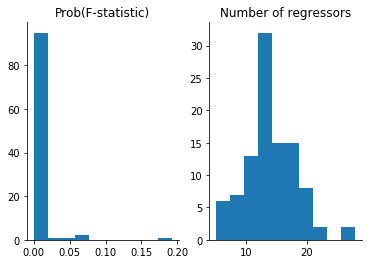

In [16]:
plot_freedman_exercise(df)

### Resources

* **Goldberger, A. S. (1991)**. [A course in econometrics](https://www.hup.harvard.edu/catalog.php?isbn=9780674175440). Cambridge, MA: *Harvard University Press*.

*  **F. J. Anscombe (1973)**. [Graphs in Statistical Analysis](https://www.sjsu.edu/faculty/gerstman/StatPrimer/anscombe1973.pdf). The American Statistician, 27, 17–21. 

* **Freedman, David A.; Freedman, David A. (1983)**. [A Note on Screening Regression Equations](doi:10.1080/00031305.1983.10482729). *The American Statistician*. 37 (2), 152–155.